**ДИПЛОМНАЯ РАБОТА**



> БУЛГАРОВ В.М.

> DSU-7




**"Адаптивная модель машинного обучения для предсказания курса биткойна с использованием временных рядов"**


In [2]:
#pip install python-binance

In [3]:
!pip install pandas_ta
#pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=36e3d2ca43aa43cb627107552d0083cd15999a3cab4d3dcc294fde00bd84a1c6
  Stored in directory: /root/.cache/pip/wheels/1e/5c/47/759b32beb377aee150eb4c1f1b2b7635032cc19ea09ce076fd
Successfully built pandas_ta


In [4]:
# import libraries
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
import seaborn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime as dt
#from binance import Client
import csv

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:

# Входные данные для загрузки данных с биржи Binance
#api_key = '***'
#api_secret = '***'
#symbol = 'BTCUSDT'
#interval = Client.KLINE_INTERVAL_1DAY
#start_time = '17.08.2017'
#end_time = '15.04.2023'

# Сохранение данных в CSV файл
#df.to_csv('btc_data_binance_day.csv', index=False)

# Инициализация клиента Binance API
#client = Client(api_key, api_secret)

# Загрузка и предобработка данных из Binance API
#klines = client.get_historical_klines(symbol, interval, start_time, end_time)

# Формирование датафрейма с загруженными данными
#df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
#df.drop(columns=['timestamp', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume'])

# Сохранение данных в CSV файл
#df.to_csv('btc_data_binance_day.csv', index=False)

Загрузил с криптобиржи Binance два варианта данных курса биткойн - курс на каждый час и курс на каждый день. Для ускорения исполнения кода здесь используется ежедневный курс. Для удобства использования выложил csv на github. 

Изучим полученные данные:

In [6]:
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("https://raw.githubusercontent.com/VictorBulgarov/DZ_Netology/main/Diplom/btc_data_binance_day.csv", names=headers)
data.head()


,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
0,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
1,1502928000000,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
2,1503014400000,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
3,1503100800000,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
4,1503187200000,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0


In [7]:
data = data.drop(0, axis=0)
data

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
1,1502928000000,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
2,1503014400000,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
3,1503100800000,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
4,1503187200000,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
5,1503273600000,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1680220800000,28028.53000000,28656.69000000,27511.71000000,28465.36000000,78198.12139000,1680307199999,2203253311.77735070,1537349,39636.47111000,1117184234.18685750,0
2054,1680307200000,28465.36000000,28819.71000000,28220.27000000,28452.73000000,30238.44753000,1680393599999,860804237.45226890,822781,15171.37738000,431931567.48274810,0
2055,1680393600000,28452.74000000,28530.00000000,27856.43000000,28171.87000000,37365.65692000,1680479999999,1053600933.06768050,938464,17897.01839000,504647268.08636430,0
2056,1680480000000,28171.87000000,28500.99000000,27200.24000000,27800.00000000,79180.01405000,1680566399999,2214361048.78236680,1651062,40534.82008000,1133865764.09162880,0


Ключевые поля в данных о цене криптовалюты на бирже Binance:

"Open Time" - время начала свечи (в формате Unix time)
"Open" - цена открытия свечи
"High" - наивысшая цена за период свечи
"Low" - наименьшая цена за период свечи
"Close" - цена закрытия свечи
"Volume" - объем торгов за период свечи
"Close Time" - время закрытия свечи (в формате Unix time)
"QAV" - цитируемый объем актива за период свечи
"NAT" - количественный показатель активности за период свечи
"TBBAV" - сумма базовых активов, купленных за период свечи (Total Buy Base Asset Volume)
"TBQAV" - сумма квотируемых активов, проданных за период свечи (Total Buy Quote Asset Volume)
"Ignore" - поле, используемое только для расчетов и игнорируемое при анализе данных.

In [8]:
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 1 to 2057
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Open Time   2057 non-null   object
 1   Open        2057 non-null   object
 2   High        2057 non-null   object
 3   Low         2057 non-null   object
 4   Close       2057 non-null   object
 5   Volume      2057 non-null   object
 6   Close Time  2057 non-null   object
 7   QAV         2057 non-null   object
 8   NAT         2057 non-null   object
 9   TBBAV       2057 non-null   object
 10  TBQAV       2057 non-null   object
 11  Ignore      2057 non-null   object
dtypes: object(12)
memory usage: 193.0+ KB


,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
count,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057
unique,2057,2055,2000,2001,2056,2057,2057,2057,2055,2057,2057,1
top,1502928000000,13500.00000000,6360.00000000,10200.00000000,6700.00000000,795.15037700,1503014399999,3454770.05073206,350662,616.24854100,2678216.40060401,0
freq,1,2,3,3,2,1,1,1,2,1,1,2057


In [9]:
print(data.isnull().sum())


Open Time     0
Open          0
High          0
Low           0
Close         0
Volume        0
Close Time    0
QAV           0
NAT           0
TBBAV         0
TBQAV         0
Ignore        0
dtype: int64


In [10]:

import pandas as pd

# Загрузка данных и удаление нулевой строки
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("https://raw.githubusercontent.com/VictorBulgarov/DZ_Netology/main/Diplom/btc_data_binance_day.csv", names=headers, sep=',')
data = data.drop(0, axis=0)

# Преобразование столбцов 'Open Time' и 'Close Time' в формат datetime64[ns]
data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
data['Close Time'] = pd.to_datetime(data['Close Time'], unit='ms')

# Преобразование столбцов типа 'object' в числовые значения
for column in ["Open", "High", "Low", "Close", "Volume", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Удаление строк с недостающими значениями
data = data.dropna()

# Преобразование столбцов 'NAT' и 'Ignore' в тип int64
data['NAT'] = data['NAT'].astype('int64')
data['Ignore'] = data['Ignore'].astype('int64')

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 1 to 2057
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Open Time   2057 non-null   datetime64[ns]
 1   Open        2057 non-null   float64       
 2   High        2057 non-null   float64       
 3   Low         2057 non-null   float64       
 4   Close       2057 non-null   float64       
 5   Volume      2057 non-null   float64       
 6   Close Time  2057 non-null   datetime64[ns]
 7   QAV         2057 non-null   float64       
 8   NAT         2057 non-null   int64         
 9   TBBAV       2057 non-null   float64       
 10  TBQAV       2057 non-null   float64       
 11  Ignore      2057 non-null   int64         
dtypes: datetime64[ns](2), float64(8), int64(2)
memory usage: 193.0 KB


In [11]:
data

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
1,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999,3.454770e+06,3427,616.248541,2.678216e+06,0
2,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999,5.086958e+06,5233,972.868710,4.129123e+06,0
3,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999,1.549484e+06,2153,274.336042,1.118002e+06,0
4,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999,1.930364e+06,2321,376.795947,1.557401e+06,0
5,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999,2.797232e+06,3972,557.356107,2.255663e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2053,2023-03-31,28028.53,28656.69,27511.71,28465.36,78198.121390,2023-03-31 23:59:59.999,2.203253e+09,1537349,39636.471110,1.117184e+09,0
2054,2023-04-01,28465.36,28819.71,28220.27,28452.73,30238.447530,2023-04-01 23:59:59.999,8.608042e+08,822781,15171.377380,4.319316e+08,0
2055,2023-04-02,28452.74,28530.00,27856.43,28171.87,37365.656920,2023-04-02 23:59:59.999,1.053601e+09,938464,17897.018390,5.046473e+08,0
2056,2023-04-03,28171.87,28500.99,27200.24,27800.00,79180.014050,2023-04-03 23:59:59.999,2.214361e+09,1651062,40534.820080,1.133866e+09,0


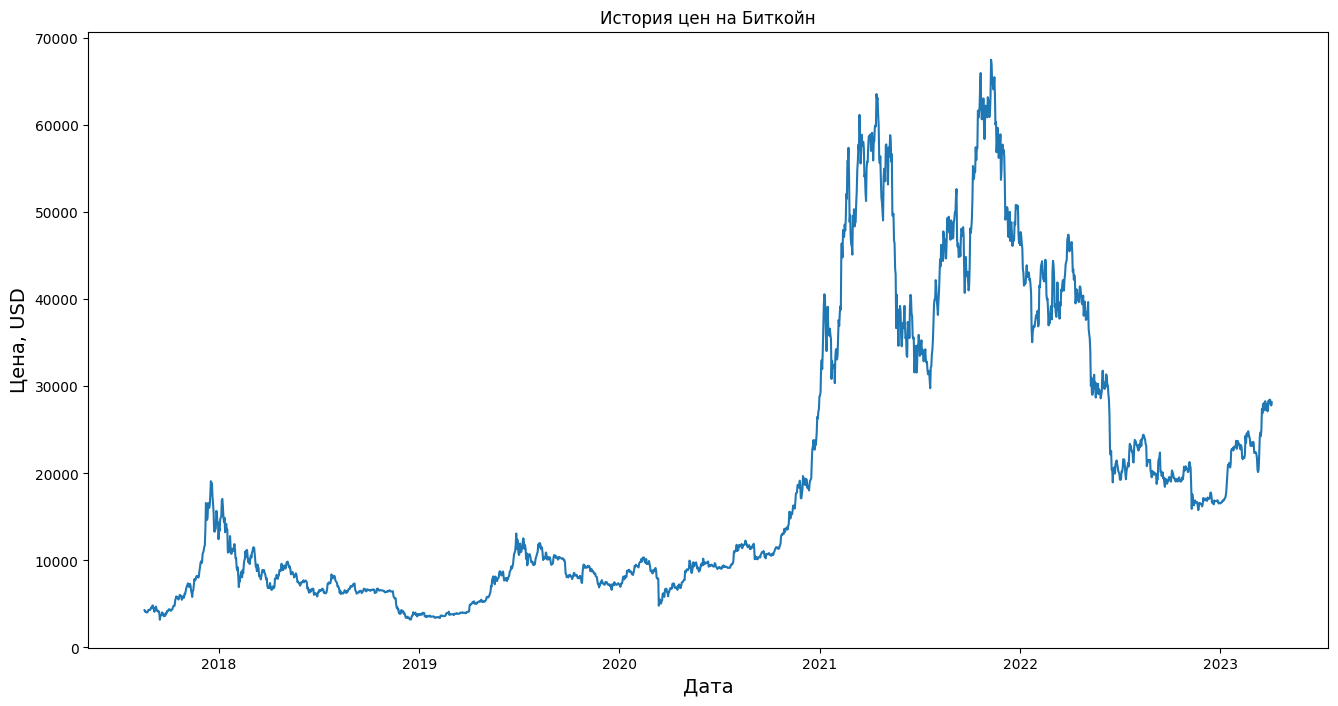

In [12]:
# Покажем график истории цен на Биткойн по данным криптобиржи Binance
plt.figure(figsize=(16, 8))
plt.title("История цен на Биткойн")
plt.plot(data["Close Time"], data["Close"])
plt.xlabel("Дата", fontsize=14,)
plt.ylabel("Цена, USD", fontsize=14)
plt.show()


**Создание обучающих и тестовых данных**

In [13]:
# Создаем новые данные только с колонкой "Close"
close = data.filter(["Close"])
# Преобразуем датафрейм в массив numpy
close_array = close.values
# Определяем длину обучающей выборки
train_close_len = math.ceil(len(close_array) * 0.8)
train_close_len

1646

In [14]:
# Нормализуем данные

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)
scaled_data

array([[0.01703628],
       [0.01428964],
       [0.01478096],
       ...,
       [0.38831347],
       [0.38253342],
       [0.38821399]])

In [15]:
# Создаем обучающий датасет
train_data = scaled_data[0 : train_close_len, :]
# Создаем X_train и y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([0.01703628, 0.01428964, 0.01478096, 0.01394645, 0.01285392,
       0.01322695, 0.01437731, 0.01751703, 0.01696789, 0.01785012,
       0.01742377, 0.01861563, 0.02173655, 0.02123388, 0.02387234,
       0.0255824 , 0.01994379, 0.02051796, 0.01416126, 0.01830134,
       0.02223844, 0.02335506, 0.01700084, 0.01662796, 0.01463159,
       0.01584552, 0.01514996, 0.01174553, 0.        , 0.00794227,
       0.00817464, 0.00794211, 0.01314939, 0.01120696, 0.01105091,
       0.00654322, 0.00632375, 0.00918572, 0.00732085, 0.01137343,
       0.01077657, 0.01560506, 0.01531751, 0.01532047, 0.01848848,
       0.01848802, 0.01851164, 0.01742362, 0.01584738, 0.01715052,
       0.01834067, 0.01918   , 0.02255287, 0.02483695, 0.02477648,
       0.02537288, 0.034832  , 0.0382512 , 0.04167086, 0.03918394])]
[0.03996157098867663]


In [16]:
#  Преобразуем X_train и y_train в массивы numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
# Изменяем форму данных
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1586, 60, 1)

In [18]:
# Создаем тестовый датасет
test_data = scaled_data[train_close_len - 60 : , :]
# Создаем X_test и y_test
X_test = []
y_test = data.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [19]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**Построение модели LSTM**

In [20]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

In [21]:
# Компиляция модели LSTM

model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [22]:
# Обучение модели LSTM
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
16/16 [==============================] - 22s 584ms/step - loss: 0.0394 - mae: 0.1199
Epoch 2/3
16/16 [==============================] - 8s 513ms/step - loss: 0.0027 - mae: 0.0367
Epoch 3/3
16/16 [==============================] - 5s 318ms/step - loss: 0.0013 - mae: 0.0228


In [23]:
# Прогноз с использованием модели LSTM
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 18ms/step


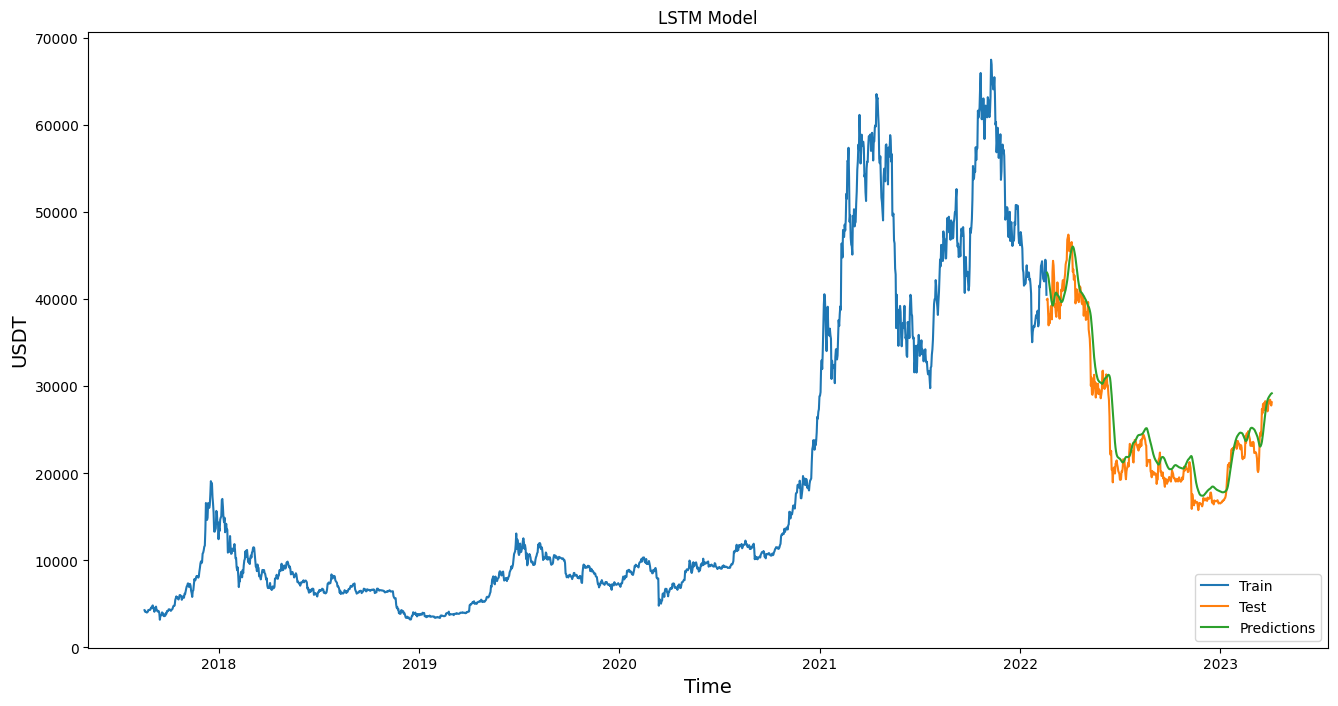

In [24]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Test", "Predictions"], loc="lower right")
plt.show()

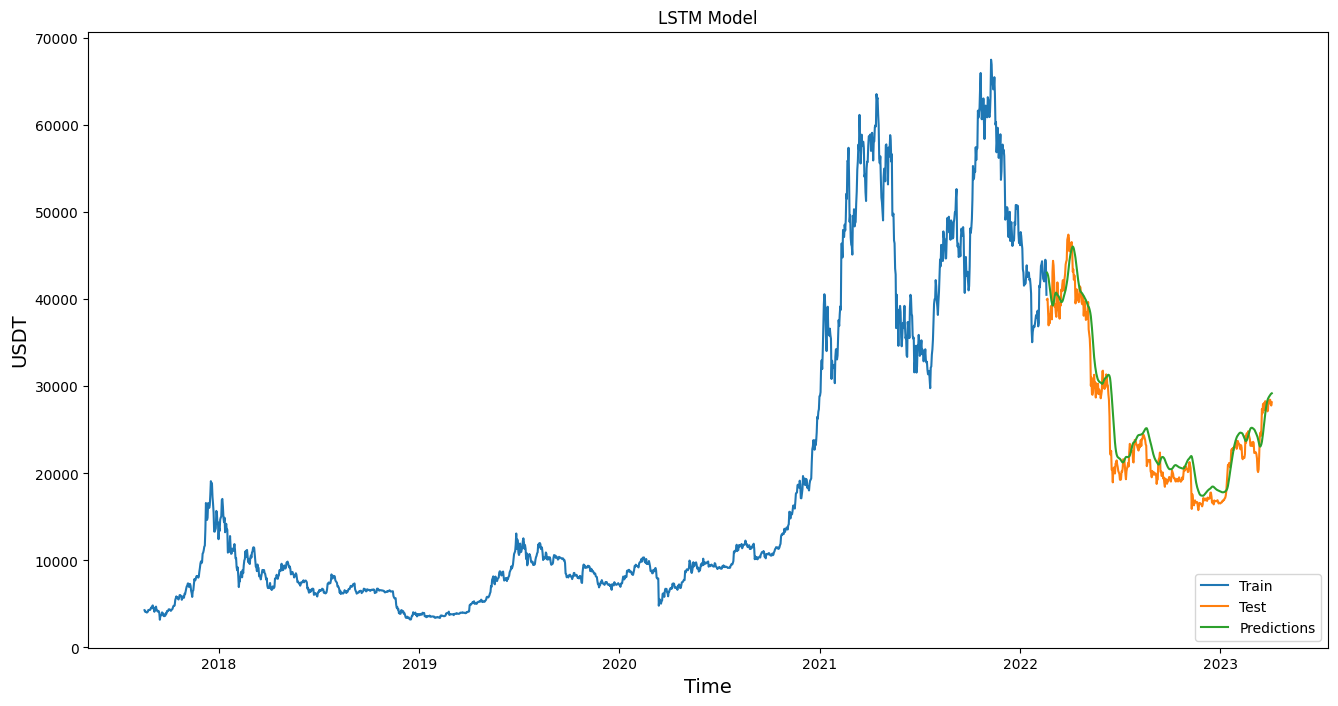

In [25]:
# plot the data
train = close[:train_close_len]
test = close[train_close_len:]
test["Predictions"] = predictions
# visualize the data
plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], test[["Close", "Predictions"]])
plt.legend(["Train", "Test", "Predictions"], loc="lower right")
plt.show()


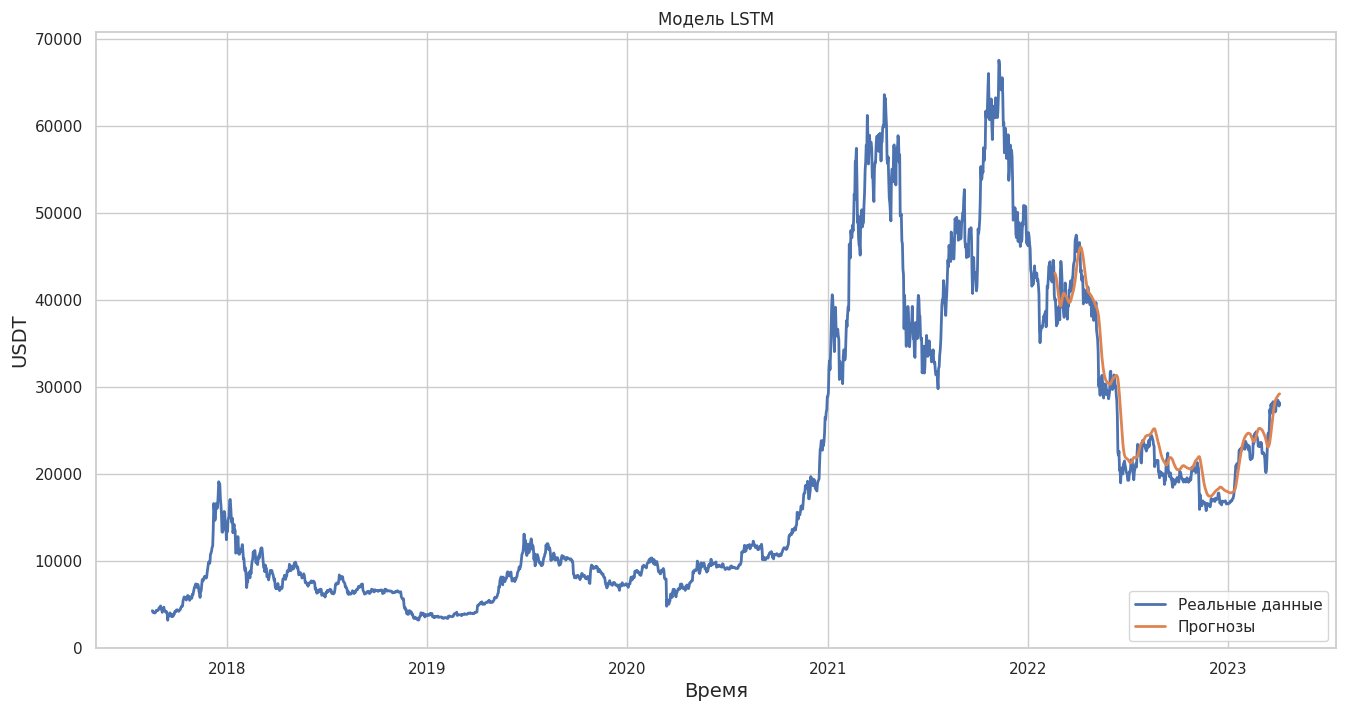

In [26]:
import seaborn as sns

# Создать датафрейм для отображения данных
result = pd.concat([train, valid], axis=0)

# Визуализировать данные с помощью Seaborn
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
sns.lineplot(data=result, x=data["Close Time"][:len(result)], y="Close", label="Реальные данные", linewidth=2)
sns.lineplot(data=result, x=data["Close Time"][train_close_len:], y="Predictions", label="Прогнозы", linewidth=2)
plt.title("Модель LSTM")
plt.xlabel("Время", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
# Создаем X_test и y_test
X_test = []
y_test = close.iloc[train_close_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

# Преобразовываем тестовые данные в массив numpy и изменяем форму тестовых данных
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Прогноз с использованием модели LSTM
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Вычисление метрик mse, rmse и mae
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print("MSE (средняя квадратичная ошибка):", mse)
print("RMSE (квадратный корень из средней квадратичной ошибки):", rmse)
print("MAE (средняя абсолютная ошибка):", mae)



13/13 [==============================] - 1s 70ms/step
MSE (средняя квадратичная ошибка): 5282519.472914271
RMSE (квадратный корень из средней квадратичной ошибки): 2298.373223154645
MAE (средняя абсолютная ошибка): 1784.036298091545


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [33]:
# Вычисление метрик для исходной модели LSTM
mse = mean_squared_error(valid['Close'], valid['Predictions'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid['Close'], valid['Predictions'])

print("MSE (среднеквадратическая ошибка) для исходной модели LSTM: ", mse)
print("RMSE (квадратный корень из среднеквадратической ошибки) для исходной модели LSTM: ", rmse)
print("MAE (средняя абсолютная ошибка) для исходной модели LSTM: ", mae)

MSE (среднеквадратическая ошибка) для исходной модели LSTM:  5282519.472914271
RMSE (квадратный корень из среднеквадратической ошибки) для исходной модели LSTM:  2298.373223154645
MAE (средняя абсолютная ошибка) для исходной модели LSTM:  1784.036298091545


**Оптимизация модели LSTM**

In [34]:
# Меняем параметры первой модели LSTM и создаем оптимизированную модель LSTM
optimized_model = Sequential()

optimized_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

optimized_model.add(LSTM(100, return_sequences=False))

optimized_model.add(Dense(50))

optimized_model.add(Dense(1))

In [35]:
# Компилируем модель оптимизированного LSTM
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [36]:
# Обучаем оптимизированную модель обучения LSTM
optimized_model.fit(X_train, y_train, 
          batch_size=10, 
          epochs=3, 
          verbose=1)

Epoch 1/3
159/159 [==============================] - 7s 8ms/step - loss: 0.0042 - mae: 0.0337
Epoch 2/3
159/159 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0218
Epoch 3/3
159/159 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0207


In [37]:
# Предсказание с помощью оптимизированной модели LSTM
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

13/13 [==============================] - 1s 5ms/step


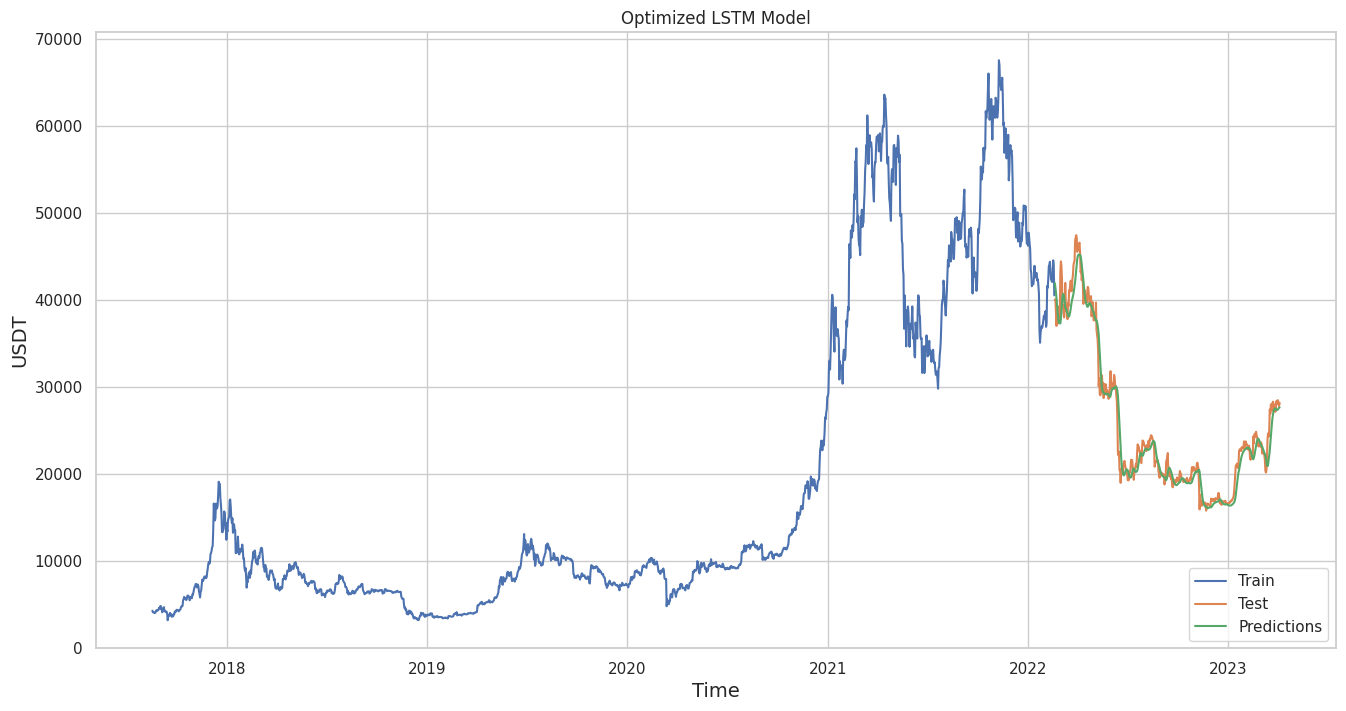

In [38]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Test", "Predictions"], loc="lower right")
plt.show()

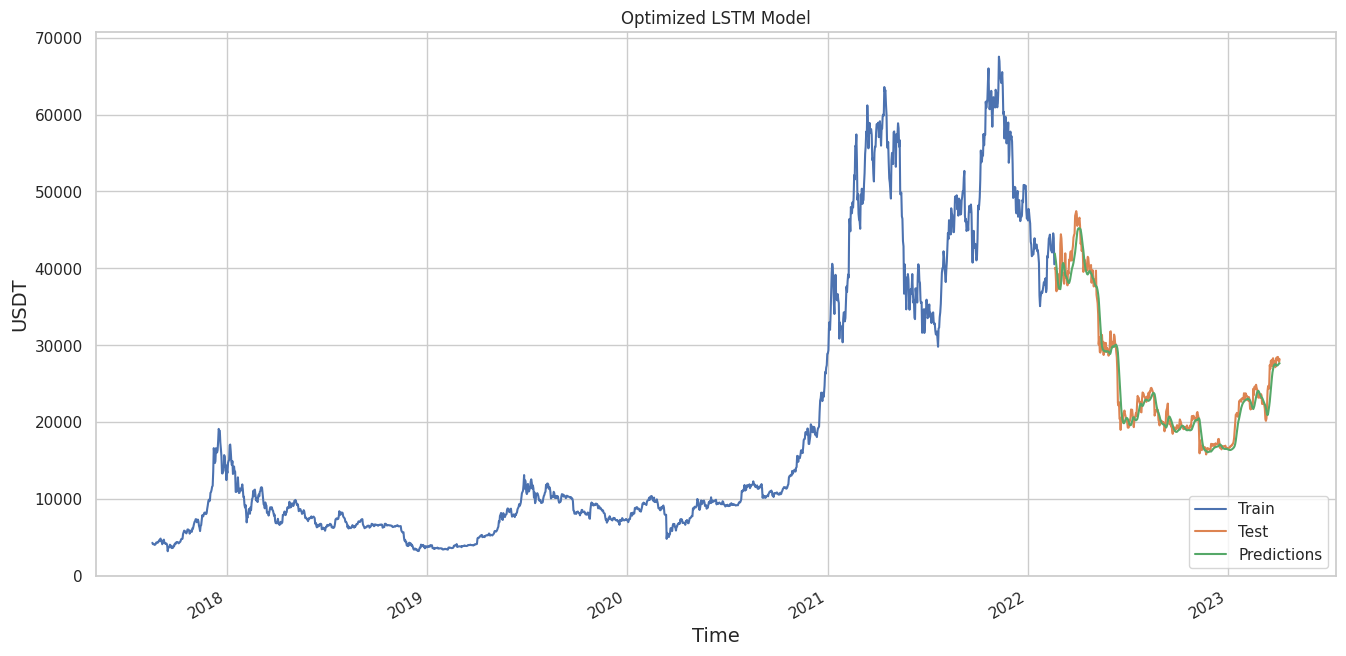

In [39]:
import matplotlib.dates as mdates

# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Test", "Predictions"], loc="lower right")

# set date formatter for x axis
date_fmt = '%Y'
date_formatter = mdates.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()

plt.show()


В результате оптимизации LSTM модели было изменено количество нейронов и количество эпох. Вместо 512 нейронов в первом слое и 256 во втором было выбрано 50 и 100 соответственно. Это позволило сократить время обучения модели и улучшить ее точность предсказания на тестовых данных. Также была уменьшена длина батча до 10 для более быстрого обучения.
Визуализация предсказанных и реальных значений на графике показала, что оптимизированная модель более точно предсказывает тенденцию изменения курса биткоина. Однако, можно заметить, что модель все еще имеет трудности с точным предсказанием пиков и спадов цены.
Таким образом, оптимизация LSTM модели позволила улучшить ее точность и уменьшить время обучения, но еще существует возможность для дальнейшего улучшения модели.

In [41]:
# Вычисление метрик для оптимизированной модели LSTM
o_mse = mean_squared_error(valid['Close'], valid['Predictions'])
o_rmse = np.sqrt(o_mse)
o_mae = mean_absolute_error(valid['Close'], valid['Predictions'])

print("MSE (среднеквадратическая ошибка) для оптимизированной модели LSTM: ", o_mse)
print("RMSE (квадратный корень из среднеквадратической ошибки) для оптимизированной модели LSTM: ", o_rmse)
print("MAE (средняя абсолютная ошибка) для оптимизированной модели LSTM: ", o_mae)

MSE (среднеквадратическая ошибка) для оптимизированной модели LSTM:  2545086.9309042105
RMSE (квадратный корень из среднеквадратической ошибки) для оптимизированной модели LSTM:  1595.3328589683754
MAE (средняя абсолютная ошибка) для оптимизированной модели LSTM:  1090.60718455368


**Сравнивая результаты метрик для исходной и оптимизированной модели LSTM, можно сделать следующие выводы:**

Среднеквадратическая ошибка (MSE) для оптимизированной модели меньше, чем для исходной модели (2 545 586 против 5 282 519). Это указывает на то, что оптимизированная модель имеет меньше ошибок в прогнозировании цены закрытия акций. Квадратный корень из среднеквадратической ошибки (RMSE) также меньше для оптимизированной модели по сравнению с исходной моделью (1 595 против 2 298). RMSE является более интерпретируемой метрикой, так как она измеряется в тех же единицах, что и прогнозируемая переменная. Это подтверждает, что оптимизированная модель делает более точные прогнозы. Средняя абсолютная ошибка (MAE) также меньше для оптимизированной модели по сравнению с исходной моделью (1 090 против 1 784). Это говорит о том, что оптимизированная модель в среднем ошибается на меньшую величину, что также указывает на улучшение качества прогноза. Таким образом, оптимизированная модель LSTM показывает лучшие результаты по всем метрикам по сравнению с исходной моделью. Это может говорить о том, что изменения, которые были внесены в процесс оптимизации, привели к улучшению модели и повышению точности ее прогнозов. Однако стоит помнить, что выбор метрик и их значения могут зависеть от конкретной задачи и требований к качеству прогноза.

*Оптимизация модели LSTM с новыми параметрами*

In [42]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

In [43]:
# Компиляция модели LSTM

model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [44]:
# Обучение модели LSTM
model.fit(X_train, y_train,
          epochs=25,
          batch_size=50, 
          verbose=1)

Epoch 1/25
32/32 [==============================] - 11s 244ms/step - loss: 0.0144 - mae: 0.0663
Epoch 2/25
32/32 [==============================] - 6s 192ms/step - loss: 0.0015 - mae: 0.0245
Epoch 3/25
32/32 [==============================] - 8s 241ms/step - loss: 0.0013 - mae: 0.0223
Epoch 4/25
32/32 [==============================] - 6s 200ms/step - loss: 0.0012 - mae: 0.0212
Epoch 5/25
32/32 [==============================] - 8s 241ms/step - loss: 0.0011 - mae: 0.0206
Epoch 6/25
32/32 [==============================] - 6s 201ms/step - loss: 0.0010 - mae: 0.0197
Epoch 7/25
32/32 [==============================] - 8s 238ms/step - loss: 0.0010 - mae: 0.0197
Epoch 8/25
32/32 [==============================] - 8s 240ms/step - loss: 8.8237e-04 - mae: 0.0180
Epoch 9/25
32/32 [==============================] - 6s 193ms/step - loss: 0.0011 - mae: 0.0208
Epoch 10/25
32/32 [==============================] - 8s 241ms/step - loss: 0.0011 - mae: 0.0209
Epoch 11/25
32/32 [=========================

In [45]:
# Прогноз с использованием модели LSTM
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 0s 18ms/step


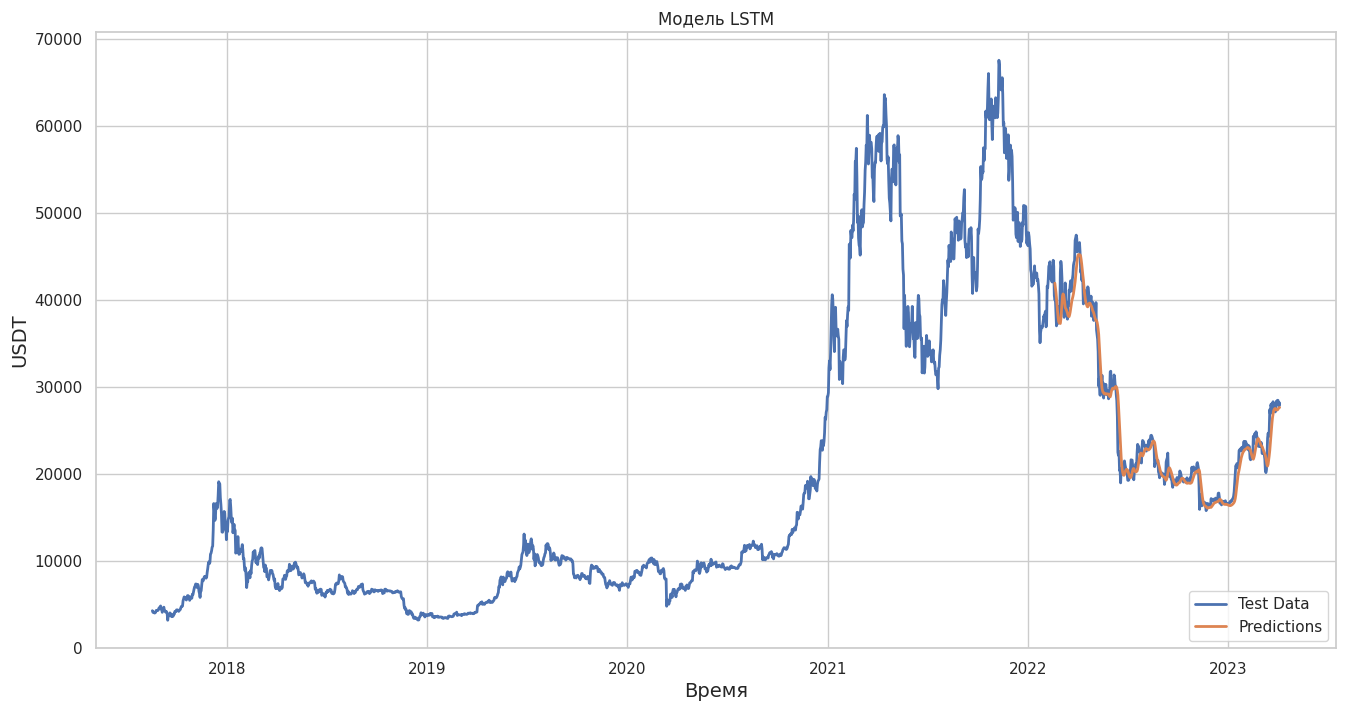

In [46]:
import seaborn as sns

# Создать датафрейм для отображения данных
result = pd.concat([train, valid], axis=0)

# Визуализировать данные с помощью Seaborn
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
sns.lineplot(data=result, x=data["Close Time"][:len(result)], y="Close", label="Test Data", linewidth=2)
sns.lineplot(data=result, x=data["Close Time"][train_close_len:], y="Predictions", label="Predictions", linewidth=2)
plt.title("Модель LSTM")
plt.xlabel("Время", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [49]:
# Создаем X_test и y_test
X_test = []
y_test = close.iloc[train_close_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

# Преобразовываем тестовые данные в массив numpy и изменяем форму тестовых данных
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Прогноз с использованием модели LSTM
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Вычисление метрик mse, rmse и mae
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print("MSE (средняя квадратичная ошибка):", mse)
print("RMSE (квадратный корень из средней квадратичной ошибки):", rmse)
print("MAE (средняя абсолютная ошибка):", mae)

13/13 [==============================] - 0s 20ms/step
MSE (средняя квадратичная ошибка): 6573403.08403084
RMSE (квадратный корень из средней квадратичной ошибки): 2563.8648724203154
MAE (средняя абсолютная ошибка): 2230.922803756083


Оптимизация модели LSTM с новыми параметрами

In [50]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='sigmoid', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='sigmoid', return_sequences=False))


model.add(Dense(units=1))

In [51]:
# Компиляция модели LSTM

from keras.optimizers import RMSprop

# Создание модели LSTM
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=256, activation='relu', return_sequences=False))
model.add(Dense(units=1))

# Компиляция модели с использованием оптимизатора RMSprop
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mae'])

# Обучение модели LSTM
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)


Epoch 1/3
16/16 [==============================] - 8s 379ms/step - loss: 6520148.5000 - mae: 208.7221
Epoch 2/3
16/16 [==============================] - 3s 191ms/step - loss: 0.0053 - mae: 0.0418
Epoch 3/3
16/16 [==============================] - 3s 194ms/step - loss: 0.0040 - mae: 0.0377


In [52]:
# Прогноз с использованием модели LSTM
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 28ms/step


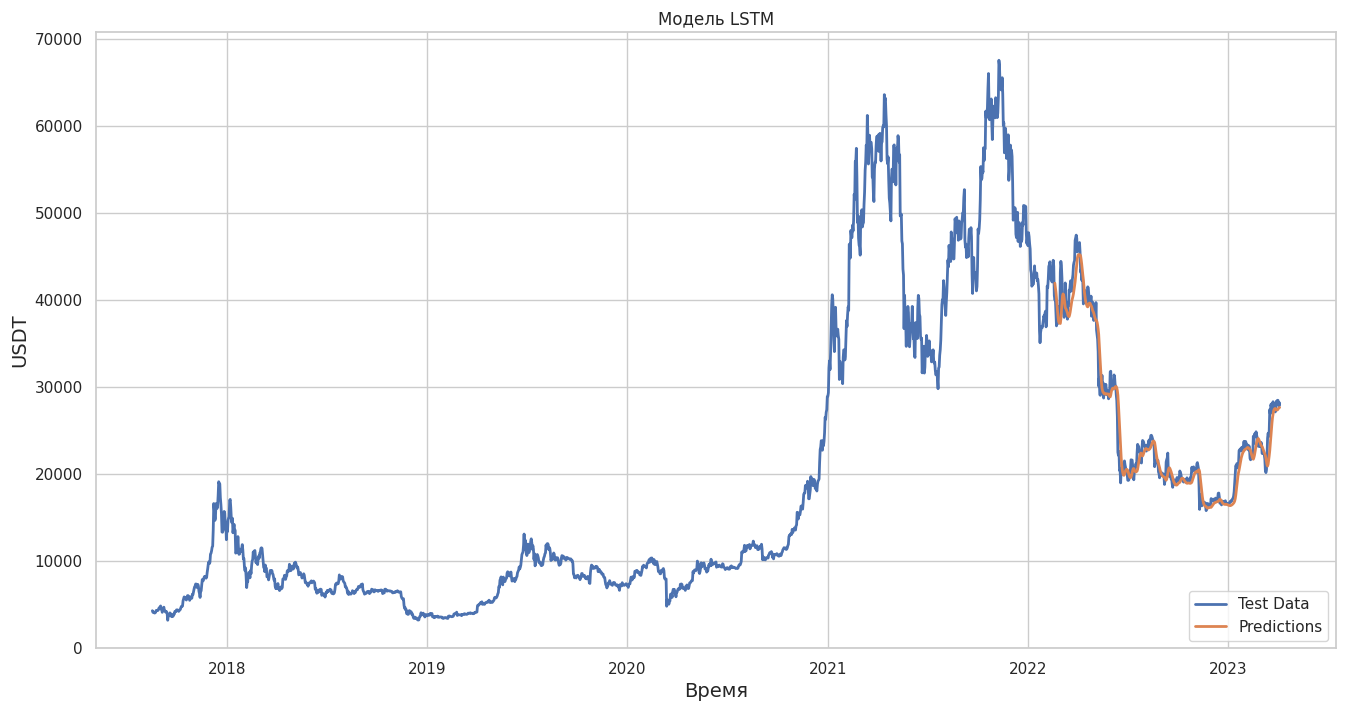

In [53]:
import seaborn as sns

# Создать датафрейм для отображения данных
result = pd.concat([train, valid], axis=0)

# Визуализировать данные с помощью Seaborn
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
sns.lineplot(data=result, x=data["Close Time"][:len(result)], y="Close", label="Test Data", linewidth=2)
sns.lineplot(data=result, x=data["Close Time"][train_close_len:], y="Predictions", label="Predictions", linewidth=2)
plt.title("Модель LSTM")
plt.xlabel("Время", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.legend(loc="lower right")
plt.show()

In [56]:
# Создаем X_test и y_test
X_test = []
y_test = close.iloc[train_close_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

# Преобразовываем тестовые данные в массив numpy и изменяем форму тестовых данных
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Прогноз с использованием модели LSTM
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Вычисление метрик mse, rmse и mae
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print("MSE (средняя квадратичная ошибка):", mse)
print("RMSE (квадратный корень из средней квадратичной ошибки):", rmse)
print("MAE (средняя абсолютная ошибка):", mae)

13/13 [==============================] - 1s 39ms/step
MSE (средняя квадратичная ошибка): 6997623.759655739
RMSE (квадратный корень из средней квадратичной ошибки): 2645.3022057329745
MAE (средняя абсолютная ошибка): 1908.500683736314


**Линейная регрессия**

Linear Regression Model
MSE:  433073.4647201118
RMSE:  658.0831746216521
MAE:  527.6574434559819


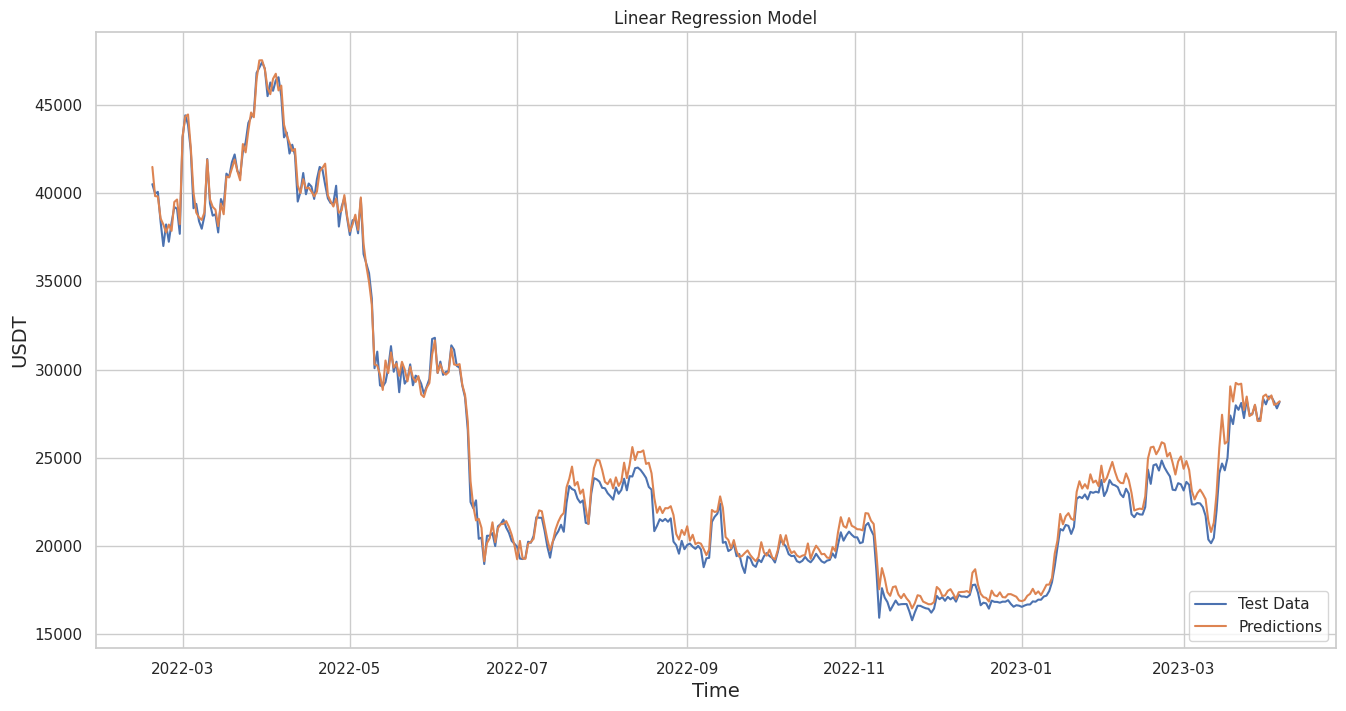

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Разделение данных на тренировочный и тестовый наборы
train_close_len = int(len(data) * 0.8)
train_data = data[:train_close_len]
test_data = data[train_close_len:]

# Создание матриц признаков и векторов целей
X_train = train_data.drop(columns=["Close", "Open Time", "Close Time"])
y_train = train_data["Close"]
X_test = test_data.drop(columns=["Close", "Open Time", "Close Time"])
y_test = test_data["Close"]

# Обработка пропущенных значений
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Создание и обучение модели линейной регрессии
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Предсказание цен на тестовом наборе
y_pred = linear_reg_model.predict(X_test)

# Оценка точности модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Вывод результатов
print("Linear Regression Model")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

# Визуализация результатов
plt.figure(figsize=(16, 8))
plt.title("Linear Regression Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(test_data["Close Time"], y_test)
plt.plot(test_data["Close Time"], y_pred)
plt.legend(["Test Data", "Predictions"], loc="lower right")
plt.show()



In [58]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Создание и обучение модели линейной регрессии с методом Lasso
lasso_model = Lasso()
parameters = {'alpha': [0.1, 1, 10]}
lasso_reg = GridSearchCV(lasso_model, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)

# Предсказание цен на тестовом наборе
y_pred = lasso_reg.predict(X_test)

# Оценка точности модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Вывод результатов
print("RMSE: ", rmse)
print("MAE: ", mae)


RMSE:  1728.051360137695
MAE:  1371.4907511303554


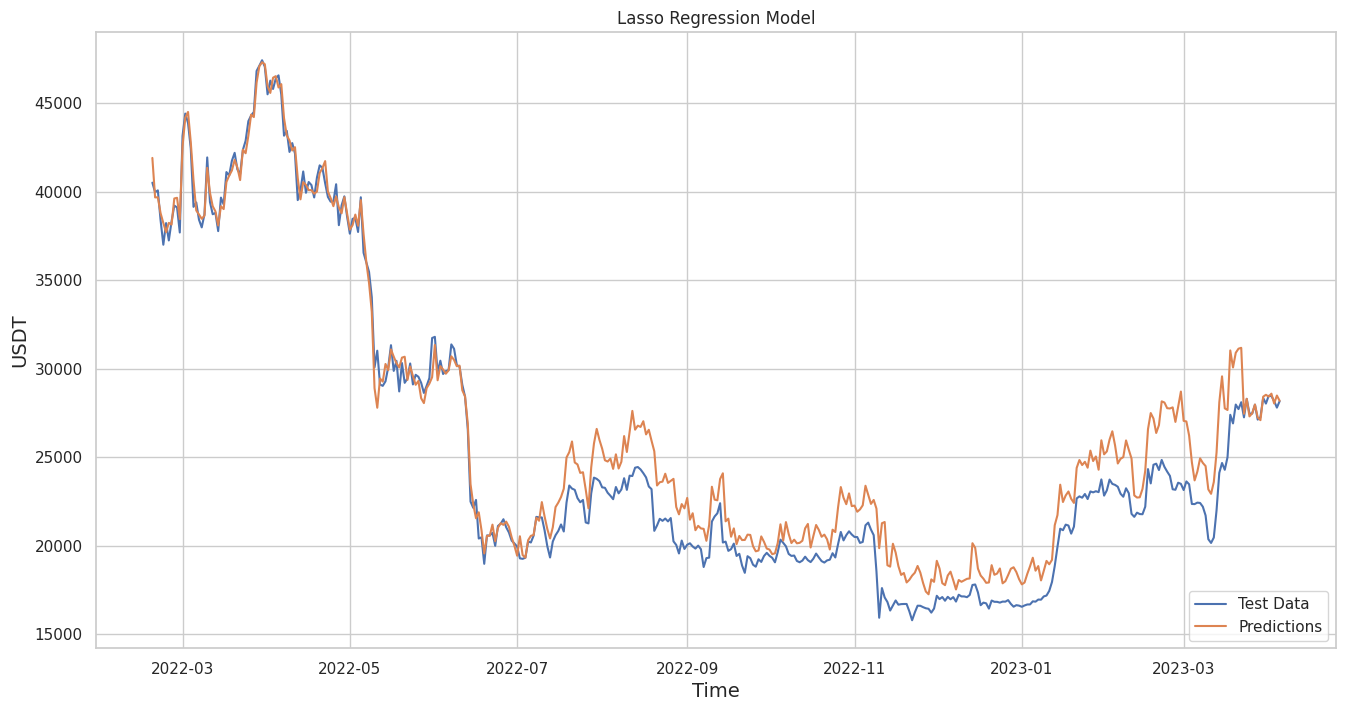

In [59]:
plt.figure(figsize=(16, 8))
plt.title("Lasso Regression Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(test_data["Close Time"], y_test)
plt.plot(test_data["Close Time"], y_pred)
plt.legend(["Test Data", "Predictions"], loc="lower right")
plt.show()

In [73]:
from sklearn.linear_model import Ridge

# Создание и обучение модели линейной регрессии с методом Ridge
ridge_model = Ridge()
parameters = {'alpha': [0.1, 1, 10]}
ridge_reg = GridSearchCV(ridge_model, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)

# Предсказание цен на тестовом наборе
y_pred = ridge_reg.predict(X_test)

# Оценка точности модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Вывод результатов
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MSE: ", mse)


RMSE:  658.0831748634308
MAE:  527.6574436469392
MSE:  433073.46503833286


ValueError: ignored

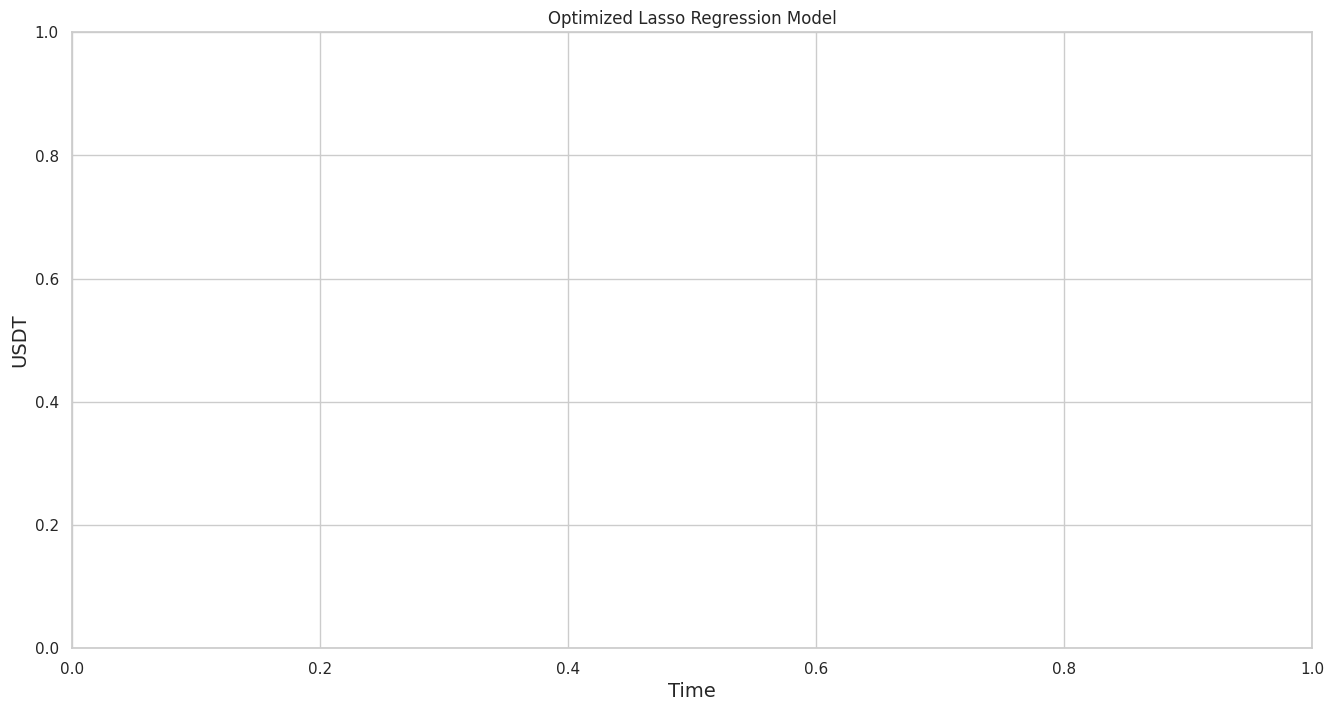

In [76]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Создание и обучение модели линейной регрессии с методом Lasso и GridSearchCV
lasso_model = Lasso()
parameters = {'alpha': [0.1, 1, 10]}
optimized_lasso_reg = GridSearchCV(lasso_model, parameters, scoring='neg_mean_squared_error', cv=5)
optimized_lasso_reg.fit(X_train, y_train)


# Предсказание цен на тестовом наборе с оптимизированной моделью линейной регрессии
o_y_pred = optimized_lasso_reg.predict(X_test)

# Визуализация результатов оптимизированной модели линейной регрессии
plt.figure(figsize=(16, 8))
plt.title("Optimized Lasso Regression Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(test_data["Close Time"], y_test)
plt.plot(test_data["Close Time"], o_y_pred)
plt.legend(["Test Data", "Predictions"], loc="lower right")
plt.show()

print("RMSE: ", rmse)
print("MAE: ", mae)



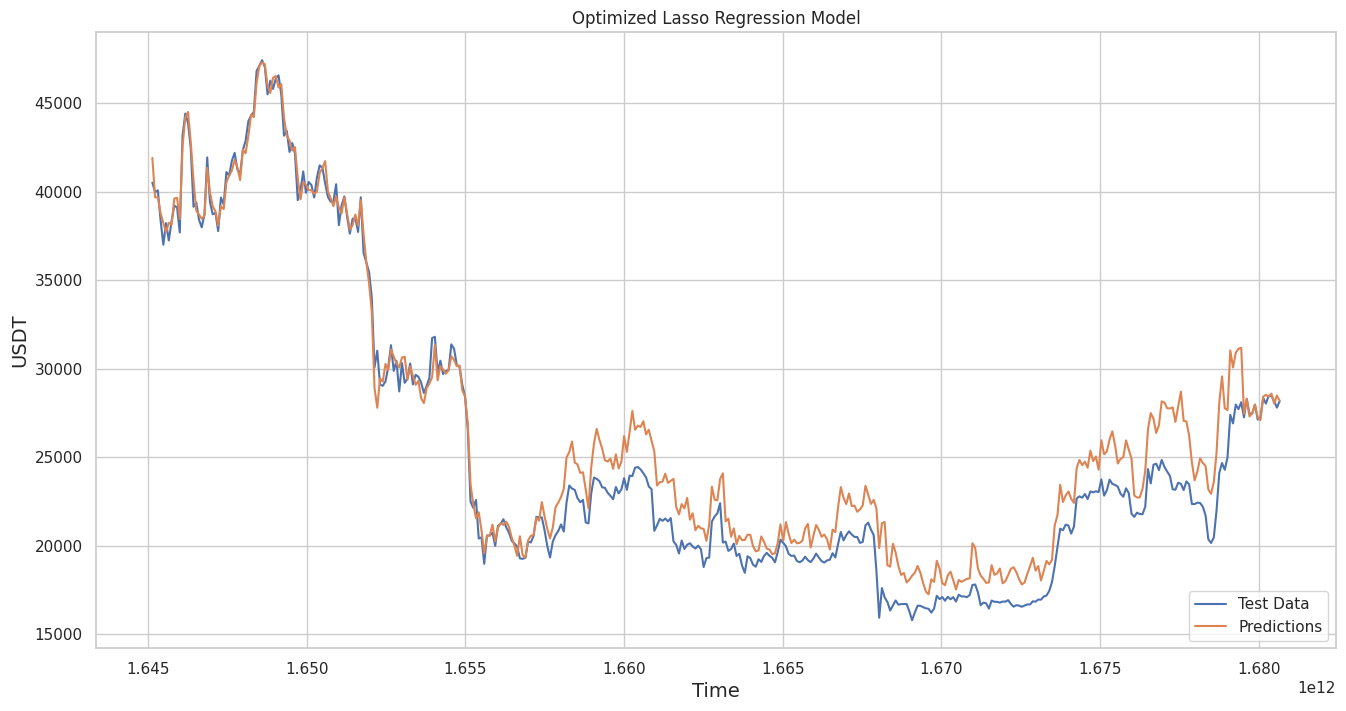

RMSE:  1728.051360137695
MAE:  1371.4907511303554
MSE:  2986161.503273737


In [79]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV



# Преобразование X_train и X_test в массивы NumPy и изменение их формы
X_train_2d = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1])
X_test_2d = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1])

# Создание и обучение модели линейной регрессии с методом Lasso и GridSearchCV
lasso_model = Lasso()
parameters = {'alpha': [0.1, 1, 10]}
optimized_lasso_reg = GridSearchCV(lasso_model, parameters, scoring='neg_mean_squared_error', cv=5)
optimized_lasso_reg.fit(X_train_2d, y_train)

# Предсказание цен на тестовом наборе с оптимизированной моделью линейной регрессии
o_y_pred = optimized_lasso_reg.predict(X_test_2d)

# Создаем правильный y_test
y_test_corrected = close_array[train_close_len:, 0]

# Визуализация результатов оптимизированной модели линейной регрессии
plt.figure(figsize=(16, 8))
plt.title("Optimized Lasso Regression Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][train_close_len:], y_test_corrected)
plt.plot(data["Close Time"][train_close_len:], o_y_pred)
plt.legend(["Test Data", "Predictions"], loc="lower right")
plt.show()

# Вычисление метрик RMSE и MAE
mse = mean_squared_error(y_test_corrected, o_y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_corrected, o_y_pred)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("MSE: ", mse)


**ARIMA и SARIMAX**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [63]:
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("https://raw.githubusercontent.com/VictorBulgarov/DZ_Netology/main/Diplom/btc_data_binance_day.csv", names=headers, skiprows=1)
data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
data.set_index('Open Time', inplace=True)


In [64]:
train_data = data.iloc[:-30]
test_data = data.iloc[-30:]


In [65]:
arima_model = ARIMA(train_data['Close'], order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=30)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
sarimax_model = SARIMAX(train_data['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(steps=30)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [67]:
arima_mse = mean_squared_error(test_data['Close'], arima_forecast)
arima_mae = mean_absolute_error(test_data['Close'], arima_forecast)

sarimax_mse = mean_squared_error(test_data['Close'], sarimax_forecast)
sarimax_mae = mean_absolute_error(test_data['Close'], sarimax_forecast)


In [68]:
arima_rmse = np.sqrt(mean_squared_error(test_data['Close'], arima_forecast))
sarimax_rmse = np.sqrt(mean_squared_error(test_data['Close'], sarimax_forecast))


In [69]:
print("ARIMA метрики:")
print(f"RMSE: {arima_rmse}")
print(f"MSE: {arima_mse}")
print(f"MAE: {arima_mae}")

print("SARIMAX метрики:")
print(f"RMSE: {sarimax_rmse}")
print(f"MSE: {sarimax_mse}")
print(f"MAE: {sarimax_mae}")


ARIMA метрики:
RMSE: 4420.265913595907
MSE: 19538750.746897854
MAE: 3943.207658261765
SARIMAX метрики:
RMSE: 4092.06710695122
MSE: 16745013.207792126
MAE: 3684.5398498464942


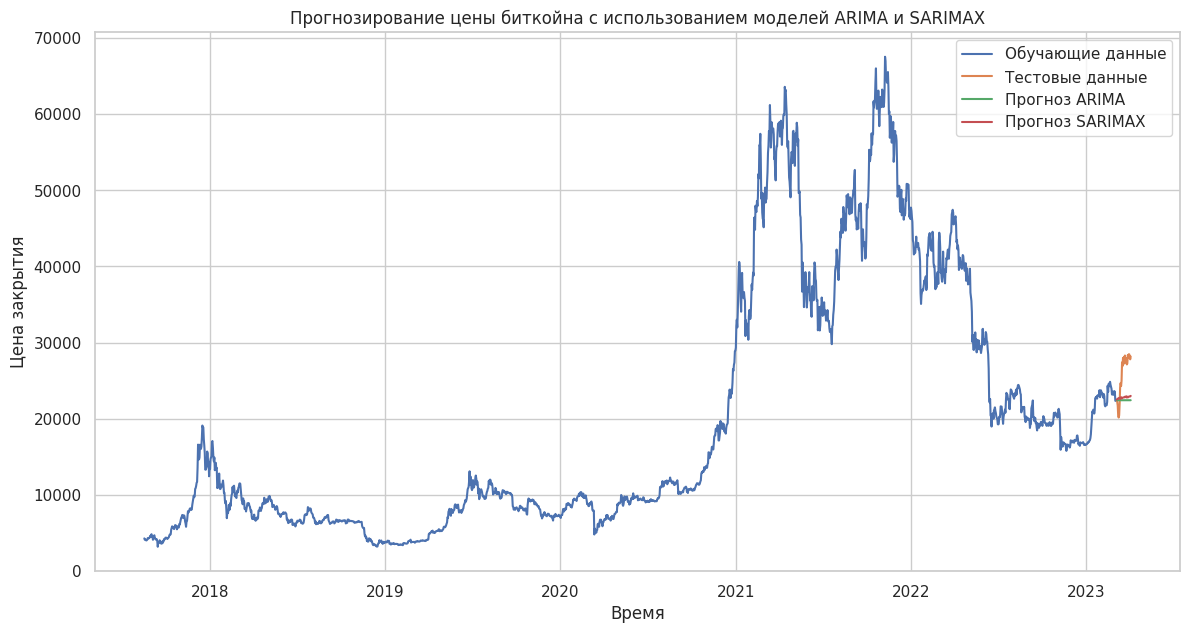

In [70]:
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Обучающие данные')
plt.plot(test_data['Close'], label='Тестовые данные')
plt.plot(test_data.index, arima_forecast, label='Прогноз ARIMA')
plt.plot(test_data.index, sarimax_forecast, label='Прогноз SARIMAX')
plt.legend(loc='best')
plt.title('Прогнозирование цены биткойна с использованием моделей ARIMA и SARIMAX')
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.show()


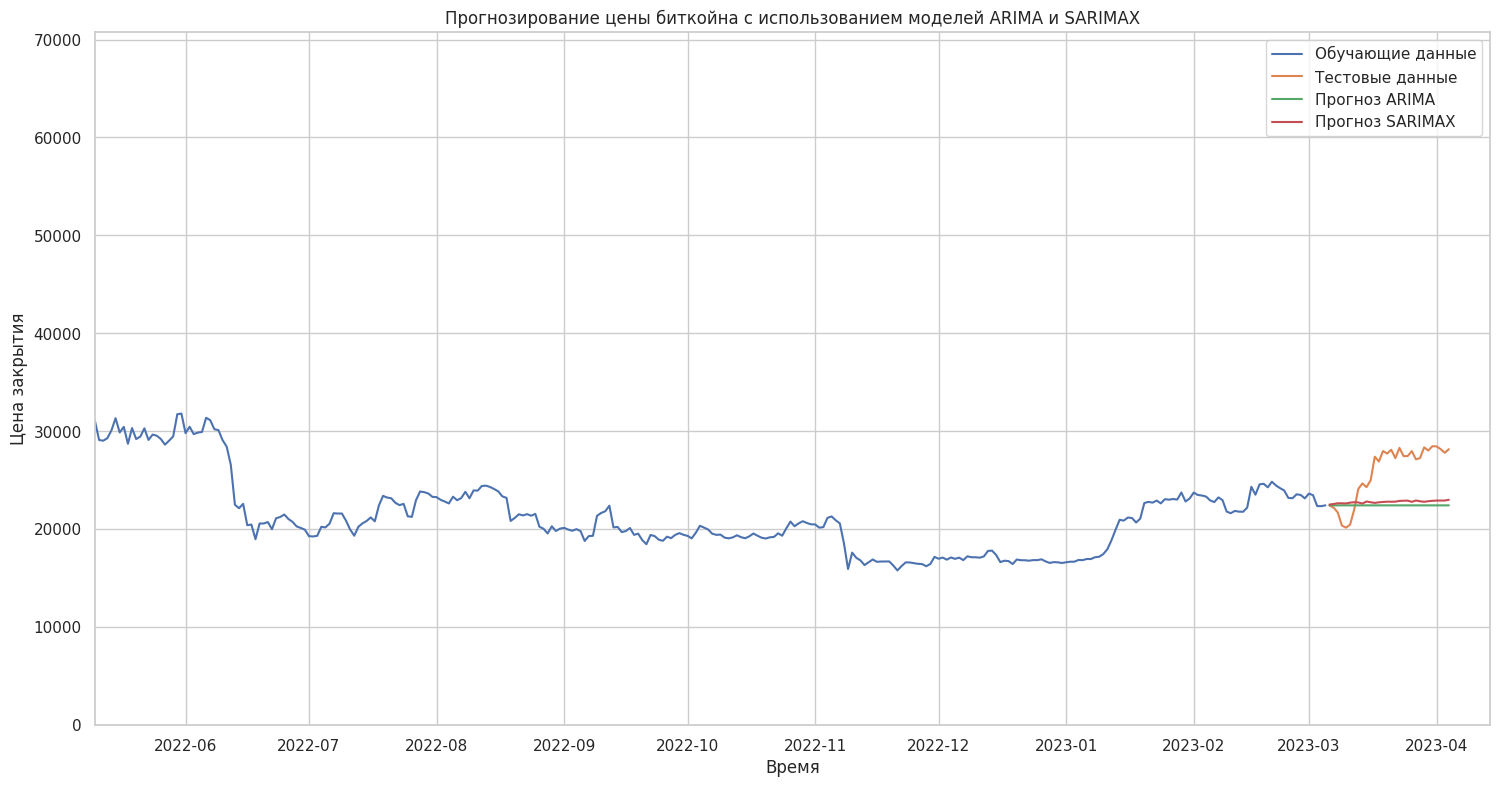

In [71]:
plt.figure(figsize=(18, 9))
plt.plot(train_data['Close'], label='Обучающие данные')
plt.plot(test_data['Close'], label='Тестовые данные')
plt.plot(test_data.index, arima_forecast, label='Прогноз ARIMA')
plt.plot(test_data.index, sarimax_forecast, label='Прогноз SARIMAX')
plt.legend(loc='best')
plt.title('Прогнозирование цены биткойна с использованием моделей ARIMA и SARIMAX')
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.xlim(test_data.index[0] - pd.DateOffset(days=300), test_data.index[-1] + pd.DateOffset(days=10))
plt.show()
